In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error

import numpy as np

#### this function builds a Quantum Fourier Transform gate
(this should be double with a qiskit library too, but I couldn't convert later circuits to gate that way)

In [2]:
def QuantumFourierTransform(digits: int):
    
    QRegY = QuantumRegister(digits)
    
    QC = QuantumCircuit(QRegY)

    for i in range(len(QRegY)):
        QC.h(QRegY[i])

        theta = np.pi / 2
        for j in range(i + 1, len(QRegY)):
            QC.cp(theta, QRegY[j], QRegY[i])
            theta /= 2
    
    for i in range(digits >> 1):
        QC.swap(QRegY[i],QRegY[- (i + 1)])
    
    return QC.to_gate()

#### the following function builds a gate (oracle) that transforms $| x \rangle | y \rangle$ to $| x \rangle | y - f(x) \rangle$

In [3]:
def EnergyOracle(GraphLaplacian: list[list[int]], digits: int):

    QRegX = QuantumRegister(len(GraphLaplacian))
    QRegY = QuantumRegister(digits)
    
    QFT = QuantumFourierTransform(digits)

    QC = QuantumCircuit(QRegX, QRegY)
    QC.append(QFT, QRegY)

    # Phasers
    for i in range(len(GraphLaplacian)):
        theta = - GraphLaplacian[i][i] * np.pi
        for j in range(len(QRegY)):
            QC.cp(theta, QRegX[i], QRegY[j])
            theta /= 2

        for j in range(i + 1, len(GraphLaplacian[i])):
            if GraphLaplacian[i][j] != 0:
                theta = - 2 * GraphLaplacian[i][j] * np.pi
                for k in range(len(QRegY)):
                    QC.mcp(theta, [QRegX[i], QRegX[j]], QRegY[k])
                    theta /= 2

    QC.append(QFT.inverse(), QRegY)

    return QC.to_gate()

#### the following creates the Grover fixed point circuit, $S_L = G \left( \alpha_l, \beta_l \right) \cdots G \left( \alpha_1, \beta_1 \right) H^{\otimes n}$

In [4]:
def GroverFixedPointGate(GraphLaplacian: list[list[int]], digits: int, l: int, delta: float):

    gamma = np.sqrt(1 - 1 / pow(np.cosh(np.arccosh(1 / delta) / (2 * l + 1)), 2))

    alpha = [2 * np.arctan(1 / (gamma * np.tan(2 * np.pi * j / (2 * l + 1)))) for j in range(1, l + 1)]
    
    U_f = EnergyOracle(GraphLaplacian, digits)

    QRegX = QuantumRegister(len(GraphLaplacian), "x")
    QRegY = QuantumRegister(digits, "y")

    QC = QuantumCircuit(QRegX, QRegY)

    QC.h(QRegX)

    for j in range(l):
        # S_t (beta)
        QC.append(U_f, QRegX[:] + QRegY[:])
        QC.p(alpha[l - 1 - j], QRegY[0])
        if i != l - 1: # the last one is not needed
            QC.append(U_f.inverse(), QRegX[:] + QRegY[:])
        
        # S_s (alpha)
        QC.h(QRegX)
        QC.x(QRegX)
        # can we improve on mcp???
        QC.mcp(alpha[j], QRegX[:-1], QRegX[-1])
        QC.x(QRegX)
        QC.h(QRegX)

    return QC.to_gate()

#### the following builds the circuit for the new QAOA

In [5]:
def GroverQAOACircuit(GraphLaplacian: list[list[int]], digits: int, y: int, delta: float, l: int, bangs: list[list[int]], ShotNumber: int):

    # one quantum/classical register pair for each vertex
    QRegX = QuantumRegister(len(GraphLaplacian), "x")
    ClRegX = ClassicalRegister(len(GraphLaplacian), "cl-x")

    # quantum registers to digitize y
    QRegY = QuantumRegister(digits, "y")

    QC = QuantumCircuit(QRegX, QRegY, ClRegX)

    GroverMixer = GroverFixedPointGate(GraphLaplacian, digits, l, delta)
    GroverMixer.label = "GroverMixer"
    InverseGroverMixer = GroverMixer.inverse()
    InverseGroverMixer.label = "GroverMixerInverse"

    for i in range(len(QRegX)):
        QC.initialize([1, 0], QRegX[i])

    for i in range(len(QRegY)):
        # y - 1 is used, so states with f(x) >= y are flagged
        QC.initialize([1 - ((y - 1) >> (digits - i - 1))%2, ((y - 1) >> (digits - i - 1))%2], QRegY[i])

    QC.append(GroverMixer, QRegX[:] + QRegY[:])

    # the bangs / p = len(bangs) / going backward per convention
    for k in range(len(bangs) - 1, - 1, - 1):

        # this implements the phase-bang
        for i in range(digits):
            QC.p(bangs[k][1] * (1 << (digits - 1 - i)), QRegY[i])

        # this is the Grover-bang
        QC.append(InverseGroverMixer, QRegX[:] + QRegY[:])
        QC.x(QRegX)
        # can we improve on mcp???
        QC.mcp(bangs[k][0], QRegX[:-1], QRegX[-1])
        QC.x(QRegX)
        QC.append(GroverMixer, QRegX[:] + QRegY[:])

    QC.measure(QRegX, ClRegX)
    
    # error probabilities
    p_reset = 0.03
    p_meas = 0.1
    p_gate1 = 0.05

    # QuantumError objects (???)
    error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
    error_gate2 = error_gate1.tensor(error_gate1)
    
    # errors to noise model
    noise_bit_flip = NoiseModel()
    noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
    noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
    noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
    noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

    # simulation
    noisy_simulator = AerSimulator(noise_model=noise_bit_flip)
    compiled_QC = transpile(QC, noisy_simulator)    
    counts = noisy_simulator.run(compiled_QC, shots=ShotNumber).result().get_counts(compiled_QC)
    
    results = [[np.array([int(x) for x in s[::-1]]), 0, counts[s] * 100 / ShotNumber] for s in counts]
    for c in results:
        c[1] = np.matmul(c[0], np.matmul(GraphLaplacian, np.transpose(c[0])))

    return results

## TESTING:

### parameters

In [6]:
# independent inputs
NumberOfVerticies = 8
RootLambda = 1/2 # ratio of good states to all states
P_L = 0.9
ShotNumber = 1
BetaGrid = 3
GammaGrid = 3

# from the input we compute the following
delta = np.sqrt(1 - P_L)
l = int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - RootLambda * RootLambda)))) >> 1

# create large, random graph
GraphLaplacian = np.zeros((NumberOfVerticies, NumberOfVerticies), dtype=int)
for i in range(NumberOfVerticies):
    for j in range(i + 1, NumberOfVerticies):
        if np.random.randint(0, 2) == 1:
            GraphLaplacian[i][j] = - 1
            GraphLaplacian[j][i] = - 1
    GraphLaplacian[i][i] = - np.sum(GraphLaplacian[i])

           
NumberOfEdges = np.trace(GraphLaplacian) >> 1

NumberOfComponents = NumberOfVerticies - np.linalg.matrix_rank(GraphLaplacian)
print("number of components =",NumberOfComponents)

y = (4 * NumberOfVerticies + int(np.sqrt(8 * NumberOfVerticies + 1) - 1)) // 8 if NumberOfComponents == 1 else (2 * NumberOfVerticies + NumberOfEdges - 1) // 4 # one less then the Erdos-Edwards bound
digits = int(np.ceil(np.log2(NumberOfEdges))) + 1 # + 1 for the sign

number of components = 1


the adjacency matrix:
[[0 1 1 0 1 1 1 1]
 [1 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 1 0]
 [0 0 0 0 1 1 0 1]
 [1 0 0 1 0 1 0 0]
 [1 0 0 1 1 0 0 1]
 [1 1 1 0 0 0 0 0]
 [1 0 0 1 0 1 0 0]]


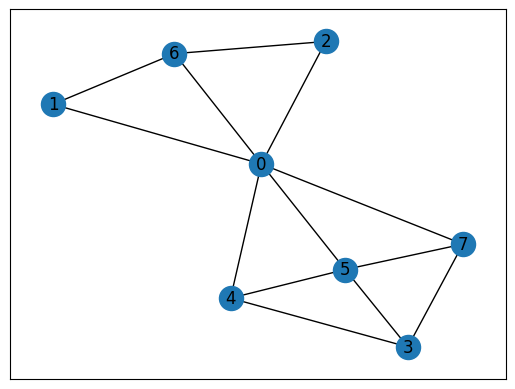

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

def createGraph(adjM):
  edges=[]
  noofvertices=len(adjM)
  for mat in adjM:
    if len(mat)>noofvertices or len(mat)<noofvertices:
      print("False Adjacency Matrix")
      return 0
  for i in range(len(adjM)):
    mat=adjM[i]
    for j in range(len(mat)):
      if mat[j]==1:
        temp=[i,j]
        edges.append(temp)
  G=nx.Graph()
  G.add_edges_from(edges)
  nx.draw_networkx(G)
  plt.show()

A = np.zeros((NumberOfVerticies, NumberOfVerticies), dtype=int)
for i in range(NumberOfVerticies):
    for j in range(i + 1, NumberOfVerticies):
        A[i][j] = A[j][i] = - GraphLaplacian[i][j]

print("the adjacency matrix:")
print(A.view())
createGraph(A)

### results: naive bang-bang optimization with $p = 1$

In [ ]:
print("\nthe graph Laplacian:\n")
print(GraphLaplacian.view(),"\n")
print("number of components\t=",NumberOfComponents,"\n")
print("cut threshold\t\t=",y)
print("Grover query complexity\t=",l)
print("square root of lambda\t=",RootLambda)
print("P_L\t\t\t=",P_L * 100,"%")
print("BetaGrid\t\t=",BetaGrid)
print("GammaGrid\t\t=",GammaGrid,"\n")

x = []
MaxCut = 0

step = 0
total_step = BetaGrid * GammaGrid

for i in range(BetaGrid):
    for j in range(GammaGrid):
            counts = GroverQAOACircuit(GraphLaplacian, digits, y, delta, l, [[2 * np.pi * i / BetaGrid, np.pi * j / GammaGrid]], 1)
            cut = np.matmul(counts[0][0], np.matmul(GraphLaplacian, np.transpose(counts[0][0])))
            if cut >= MaxCut:
                if cut > MaxCut:
                    x = [[counts[0][0], [2 * np.pi * i / BetaGrid, np.pi * j / GammaGrid]]]
                    MaxCut = cut
                else:
                    x.append([counts[0][0], [2 * np.pi * i / BetaGrid, np.pi * j / GammaGrid]])
            step += 1
            print("progess =",str(int((step * 100) / total_step)) + "%")

print("\nMaxCut =",MaxCut,"\n")
print("configurations:\n")
for c in x:
    print("x\t=",c[0].view(),"\nangles\t=",c[1],"\n")
print()